In [1]:
%reload_ext autoreload
%autoreload

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.visit_attribution as visits
import nomad.filters as filters
from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1

In [3]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1) # annoying

sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)

## Analyze completeness

In [4]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

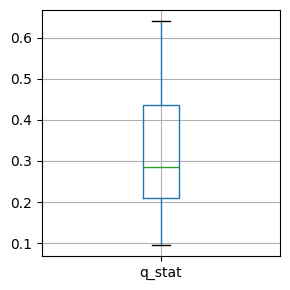

In [5]:
plt.figure(figsize=(3,3))
completeness_df.boxplot(column="q_stat")
plt.grid(True)
plt.tight_layout()

plt.show()

## Example for one user

In [6]:
# Select data from 1 user
user1 = diaries_df.uid.unique()[0]

sparse1 = sparse_df.loc[sparse_df['uid'] == user1]
diary1 = diaries_df.loc[diaries_df.uid == user1]

In [7]:
%%time
DUR_MIN=5
DT_MAX=90
DELTA_ROAM=30
# to summarize stops after groupby passing through individual locations
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id']) # < function(grouped_data)

# If we want to use 'majority' to attribute visits, then we need stop labels on each ping
_, stops_hdbscan = HDBSCAN.st_hdbscan(
                        traj=sparse1,
                        time_thresh=240,
                        min_pts=2,
                        min_cluster_size=3,
                        timestamp='timestamp',
                        x='x',
                        y='y')

# has same index as data
pred_hdbscan = visits.point_in_polygon(data=stops_hdbscan,
                                        poi_table=poi_table,
                                        method='centroid',
                                        data_crs='EPSG:3857',
                                        max_distance=10,
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')
# join the building id
stop_table_hdbscan = stops_hdbscan.join(pred_hdbscan)
stop_table_hdbscan.head()

CPU times: total: 484 ms
Wall time: 497 ms


,cluster,x,y,timestamp,duration,building_id
0,1,-4.265619e+06,4.393128e+06,1.704122e+09,137.0,w-x6-y9
1,2,-4.265575e+06,4.393197e+06,1.704154e+09,63.0,h-x8-y13
2,3,-4.265570e+06,4.393182e+06,1.704173e+09,11.0,h-x8-y13
3,4,-4.265439e+06,4.393106e+06,1.704272e+09,32.0,w-x18-y8
4,5,-4.265617e+06,4.393127e+06,1.704364e+09,233.0,w-x6-y9


In [ ]:
pred_hdbscan = visits.point_in_polygon(data=stops_hdbscan,
                                        poi_table=poi_table,
                                        method='centroid',
                                        data_crs='EPSG:3857',
                                        max_distance=10,
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')

## Execution for all users

In [ ]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
stop_detection_algos = ['oracle', 'lachesis', 'ta-dbscan', 'hdbscan']

metrics_df = pd.DataFrame()
TIME_THRESH=240
DIST_THRESH=25
MIN_PTS=2

DUR_MIN=5
DT_MAX=240
DELTA_ROAM=35

for user in tqdm(diaries_df.uid.unique()[:200], desc='Processing users'):
    for algo in stop_detection_algos:
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df.loc[diaries_df['uid'] == user].copy()
        
        if algo == 'oracle':
            # oracle says correct poi for each ping
            location = visits.oracle_map(
                sparse,
                truth,
                timestamp='timestamp',
                location_id='building_id')
            # find cluster labels with naive grid-based continuity
            labels = GRID_BASED.grid_based_labels(
                data=sparse.join(location),
                time_thresh=TIME_THRESH,
                min_pts=0, #we allow stops of duration 0, patched later
                location_id='building_id',
                traj_cols=traj_cols)
        
        elif algo == 'lachesis':
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dur_min=DUR_MIN,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            
            labels.name = 'cluster'           
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'ta-dbscan':
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'hdbscan':
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
        else:
            print(f"Algorithm {algo} not in the list!")

        # ----------- COMPUTE STOPS FROM LABELS -----------------------
        if algo != 'oracle': 
            pred = visits.point_in_polygon(data=sparse_with_cluster,
                                            poi_table=poi_table,
                                            method='majority',
                                            data_crs='EPSG:3857',
                                            max_distance=15,
                                            cluster_label='cluster',
                                            location_id='building_id',
                                            x='x',
                                            y='y')
        
            pred = sparse_with_cluster.join(pred)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            try:
                utils.invalid_stops(stops)
            except:
                labels = GRID_BASED.grid_based_labels(
                                data=pred.drop('cluster', axis=1),
                                time_thresh=TIME_THRESH,
                                min_pts=0, #we allow stops of duration 0, patched later
                                location_id='building_id',
                                traj_cols=traj_cols)
                
                pred['cluster'] = labels
                stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            
        else: #location exists by oracle, we join everything
            pred = sparse.join(location).join(labels)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            # we add a 5min duration to oracle stops with just one ping
            stops = utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp = 'start_timestamp') 

        
        # ----------- COMPUTE METRICS OF INTEREST -----------------------
        # Step 1: Compute overlaps
        #RAISE ERROR IF OVERLAPS
        overlaps = overlapping_visits(left=stops,
                                      right=truth,
                                      location_id='building_id',
                                      match_location=False)

        # Step 2: Compute visitation errors (missed, merged, split)
        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth,
                                           location_id='building_id')

        # Step 3: Compute precision, recall, and F1
        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=stops,
                                           true_visits=truth,
                                           location_id='building_id')

        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        metrics_df = pd.concat([metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

In [ ]:
# # Postprocessing based on location!
# labels = GRID_BASED.grid_based_labels(
#                 data=pred.drop('cluster', axis=1),
#                 time_thresh=TIME_THRESH,
#                 min_pts=0, #we allow stops of duration 0, patched later
#                 location_id='building_id',
#                 traj_cols=traj_cols)

# pred['cluster'] = labels
# pred = pred.loc[pred.cluster!=-1]

# merged_data_hdbscan = pred.loc[(pred.timestamp>= 1704114480)&(pred.timestamp <= 1704116340)]

In [ ]:
# %matplotlib inline
# # Merging sample data with labels
# fig, ax = plt.subplots(figsize=(6, 6))
# plt.box(on=True)
# # Plotting Garden City Map
# poi_table.plot(ax=ax, color='green', alpha=0.3)
# # Getting colors for clusters
# unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
# cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# if -1 in cluster_mapping:
#     del cluster_mapping[-1]
# mapped_clusters = merged_data_hdbscan['cluster'].map(cluster_mapping).to_numpy()
# cmap_base = plt.get_cmap('Dark2', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# # colors = [‘gray’] + list(cmap_base.colors)
# colors = list(cmap_base.colors)
# extended_cmap = mcolors.ListedColormap(colors)
# # Plotting Pings
# ax.scatter(merged_data_hdbscan['x'],
#            merged_data_hdbscan['y'],
#            c=mapped_clusters,
#            cmap=extended_cmap,
#            s=6,
#            alpha=1,
#            zorder=2)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
# # ax.set_title(“HDBSCAN Stops for Sample User”)
# ax.set_xticks([])
# ax.set_yticks([])
# # ax.set_xlim(12, 22)
# # ax.set_ylim(7, 14)
# plt.tight_layout()
# # plt.savefig(‘gc_empty.png’)
# plt.show()

In [ ]:
metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

bootstrapping=True
if bootstrapping:
    output = []
    agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
    agg_dict = {key:'median' for key in agg_keys}
    for _ in range(100):
        output += [metrics_df.sample(len(metrics_df), replace=True).groupby('algorithm', as_index=False).agg(agg_dict)]
    metrics_df = pd.concat(output)

In [ ]:
# first group: the three error‐fractions, share y‐axis [0,1]
frac_metrics = ["missed_fraction", "merged_fraction", "split_fraction"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, metric in zip(axes, frac_metrics):
    metrics_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("")           # drop the “by …” label
    ax.set_ylabel(metric if ax is axes[0] else "")  # only leftmost gets ylabel
    ax.grid(True)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, metric in zip(axes, prf_metrics):
    metrics_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.upper() if metric=="f1" else metric.title())
    ax.set_xlabel("")
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.grid(True)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
# TO DO: plot to compare algorithm with oracle, x-axis is users sorted by completeness_df.q_stat. y-axis = f1. or recall. 
# Alternatively, q_stat vs F1 scatter plot.

In [ ]:
# TO DO: plot by building area, by dwell time

In [ ]:
# TO DO: expand algorithm list. lachesis_coarse, lachesis_fine, ta_dbscan_coarse, ta_dbscan_fine, oracle_coarse, oracle_fine

## Exploration of building size

In [ ]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def classify_building(building):
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

building_sizes = {
    b_id: classify_building(b_obj)
    for b_id, b_obj in city.buildings.items()
}

building_sizes

def clasify_dwell(stop_table):
    # (low, mid, high)
    return

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.box(on=True)

# Plotting Garden City Map

city.plot_city(ax, doors=True, address=True)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
city.buildings['r-x5-y0'].blocks

In [ ]:
city.buildings

## Usage of oracle_map and location_based stop detection

In [ ]:
# Select data from 1 user
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id'])
user = diaries_df.uid.unique()[1]

sparse = sparse_df.loc[sparse_df['uid'] == user]
truth = diaries_df.loc[diaries_df.uid == user]

In [ ]:
user

In [ ]:
location = visits.oracle_map(sparse, truth, timestamp='timestamp', location_id='building_id')

In [ ]:
labels = GRID_BASED.grid_based_labels(data=sparse.join(location),
                             time_thresh=240,
                             min_pts=0,
                             datetime='local_timestamp',
                             location_id='building_id')
pred = sparse.join(location).join(labels)

In [ ]:
stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
stops = utils.pad_short_stops(stops, pad=5, start_timestamp = 'start_timestamp') # we add a little duration to oracle stops with just one ping

In [ ]:
# Step 1: Compute overlaps
overlaps = overlapping_visits(left=stops,
                              right=truth,
                              location_id='building_id',
                              match_location=False)

# Step 2: Compute visitation errors (missed, merged, split)
errors = compute_visitation_errors(overlaps=overlaps,
                                   true_visits=truth,
                                   location_id='building_id')

# Step 3: Compute precision, recall, and F1
prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                   pred_visits=stops,
                                   true_visits=truth,
                                   location_id='building_id')

In [ ]:
print(errors)
print(prf1)